In [153]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import math

import matplotlib.pyplot as plt

In [154]:
trainDF = pd.read_csv("./vaccine_train_set.csv")
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [155]:
validDF = pd.read_csv("./vaccine_validation_set.csv")
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [156]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = [ar[0] for ar in features.values]
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = [ar[0] for ar in features.values]
validLabels = validDF['label'].values

In [157]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def customPreprocessor(text: str):
    import re
    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

vectorizer = TfidfVectorizer(max_df=0.85, min_df=0.01)
#vectorizer = TfidfVectorizer(preprocessor=customPreprocessor, stop_words="english", max_df=0.85, min_df=0.01)
trainSamples = vectorizer.fit_transform(X_train)
validSamples = vectorizer.transform(X_valid)

In [158]:
from sklearn.metrics import f1_score

validPredictions = []
trainPredictions = []
trainSizes = []
lrClassifier = LogisticRegression(max_iter=math.inf)
for i in range(10, len(trainLabels), 500):
    print('\r', i, end='')
    trainSizes.append(i)
    currentBatch = trainSamples[:i]
    lrClassifier.fit(currentBatch, trainLabels[:i])
    trainPredictions.append(lrClassifier.predict(currentBatch))
    validPredictions.append(lrClassifier.predict(validSamples))

 15510

In [159]:
trainF1Scores = []
validF1Scores = []
for tp, vp in zip(trainPredictions, validPredictions):
    x = len(tp)
    trainF1Scores.append(round(f1_score(trainLabels[:x], tp, average="micro"), 4))
    validF1Scores.append(round(f1_score(validLabels, vp, average="micro"), 4))

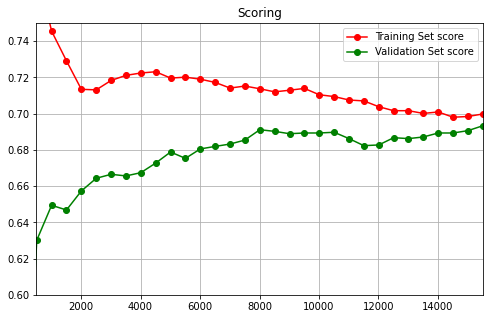

In [160]:
_, axes = plt.subplots(1, 1, figsize=(8, 5))
axes.grid()
axes.set_title('Scoring')
axes.plot(trainSizes, trainF1Scores, "o-", color="r", label="Training Set score")
axes.plot(trainSizes, validF1Scores, "o-", color="g", label="Validation Set score")
axes.set_ylim((0.6, 0.75))
axes.set_xlim((500, trainSizes[len(trainSizes) - 1]))
axes.legend(loc="best")
plt.show()